# 9. 인물사진 : Shallow Focus

In [1]:
# urllib: URL 작업을 위한 여러 모듈을 모은 패키지. (Ex. urllib.request, urllib.parse, ...)
# cv2: OpenCV 라이브러리로, 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리
# pixellib: 이미지 및 비디오 segmentation을 수행하기 위한 라이브러리. 
# pixellib.semantic: segmentation 기법 중, semantic segmentation을 쉽게 사용할 수 있도록 만든 라이브러리

import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

## 9-2. (1) 사진을 준비하자

(916, 690, 3)


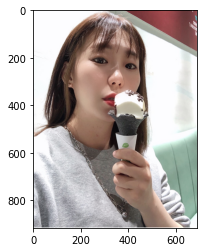

In [2]:
# os 모듈에 있는 getenv() 함수를 이용하여 읽고싶은 파일의 경로를 file_path에 저장
# 준비한 이미지 파일의 경로를 이용하여, 이미지 파일을 읽음
# cv2.imread(경로): 경로에 해당하는 이미지 파일을 읽어서 변수에 저장
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.PNG'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시, 입력은 RGB(A) 데이터 혹은 2D 스칼라 데이터
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
# plt.show(): 현재 열려있는 모든 figure를 표시 (여기서 figure는 이미지, 그래프 등)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## 9-3. (2) 세그멘테이션으로 사람 분리하기

- 이미지 세그멘테이션(image segmentation) : 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법.  이미지 세그멘테이션은 모든 픽셀에 라벨(label)을 할당하고, 라벨이 같은 객체들은 "공통적인 특징"을 가진다고 가정합니다. 이때 공통 특징은 물리적 의미가 없을 수도 있습니다. 픽셀이 비슷하게 생겼다는 사실은 인식하지만, 우리가 아는 것처럼 실제 물체 단위로 인식하지 않을 수 있는 것이죠. 물론 세그멘테이션에는 여러 가지 세부 태스크가 있으며, 태스크에 따라 다양한 기준으로 객체를 추출합니다.  

- 인스턴스 세그멘테이션(Instance segmentation) : 시맨틱 세그멘테이션은 '사람'이라는 추상적인 정보를 이미지에서 추출해 내는 방법입니다. 그래서 사람이 누구인지 관계없이 같은 라벨로 표현이 됩니다.더 나아가서 인스턴스 세그멘테이션은 사람 개개인별로 다른 라벨을 가지게 합니다. 여러 사람이 한 이미지에 등장할 때 각 객체를 분할해서 인식하자는 것이 목표입니다. 여러사람을 모두 인식하여 사람이라는 한 클래스 내에서도 각각의 개체가 구분되어 표시되면 인스턴스 세그멘테이션임.

- 시맨틱 세그멘테이션(semantic segmentation) : 세그멘테이션 중에서도 특히, 우리가 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션. 쉽게 설명하면 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법이라고 이해하시면 됩니다. 인스턴스 세그맨테이션의 데이터셋, 라벨(id,클래스라벨)이 존재하면 시맨틱 세그멘데이션으로 학습 가능.  


## 9-4. (3) 시맨틱 세그멘테이션 다뤄보기

사용되는 모델들 :  DeepLab (PixlLib로 사용함), FCN, SegNet, U-Net

In [3]:
# 저장할 파일 이름을 결정합니다
# 1. os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. model_dir 에 "/aiffel/human_segmentation/models" 저장
# 2. #os.path.join(a, b)는 경로를 병합하여 새 경로 생성 model_file 에 "/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5" 저장
# 1
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
# 2
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fa2bc843550>)

In [4]:
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

PASCAL VOC  


segmentAsPascalvoc라는 함수 이름에서 세그멘테이션 모델에 대한 힌트를 얻을 수 있는데요. PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미입니다. 모델마다 학습시킨 데이터에 따라 결괏값이 달라지므로 어떤 데이터를 학습시켰는지 확인하는 것은 매우 중요합니다.

segvalues : segmentation한 벡터값들을 이 함수에 저장함. 밑에서는 사람부분만 true, 나머지는 false로 바뀜
output : segmentation 된 이미지를 이 함수에 저장함. 밑에서는 사람누끼(사람부분만)

In [5]:
segvalues, output = model.segmentAsPascalvoc(img_path) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용

In [6]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

우리는 이 중 사람(person) 라벨, 즉 15를 가진 영역만 검출해 내고 싶습니다. 이제 사람만 어떻게 추출할 수 있을지 알아봅시다.

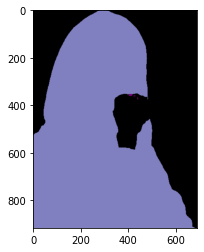

In [7]:
plt.imshow(output)
plt.show()

In [8]:
segvalues
# print(segvalues['masks'].shape)

{'class_ids': array([ 0,  5, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]])}

In [9]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bottle
person


output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨 있네요. segvalues에는 class_ids와 masks가 있습니다. class_ids를 통해 어떤 물체가 담겨 있는지 알 수 있군요!

이제 물체마다 output에 어떤 색상으로 나타나 있는지만 알아내면 될 것 같습니다.

In [10]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!

#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [11]:
colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([192, 128, 128])

In [12]:
colormap[5] #bottle

array([128,   0, 128])

여기서 주의할 것은 output 이미지가 BGR 순서로 채널 배치가 되어 있다는 점이에요. colormap은 RGB 순서이고요.

그러니 우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔 줘야 합니다.

In [13]:
seg_color = (128,128,192) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서

(916, 690)


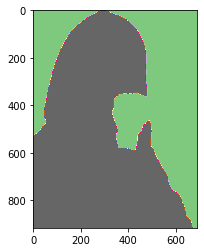

In [14]:
# seg_color로 이루어진 mask 만들기
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='Accent')
plt.show()

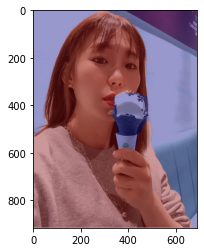

In [15]:
# 원래이미지에 겹쳐보기
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
# cv2. 적용할께 (a,b) : a에 b 필터 적용한다는 뜻
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()


In [16]:
print(img_mask.shape)

(916, 690)


## 9-5. (4) 배경 흐리게 하고, 사람은 빼기

blur() 함수 이용하기

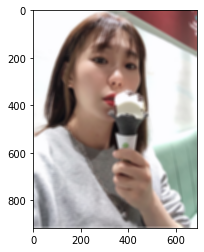

In [17]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
# cv2. 블러할께 (a,b) : a에 b 필터 블러필터적용한다는 뜻
img_orig_blur = cv2.blur(img_orig, (13,13))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
  
1. 마스크 rgb로 바꿔 읽어두고  
2. 마스크 반전작업하고  
3. 배경블러처리한 것과 마스크 반전한것을 and로 묶어준다.  

마스크 반전에서 사람이 0 이었기 때문에 어떤 값과 and 해도 사람의 부분은 0 으로 검은색이 될 수 밖에 없다. (0 = png에서는 투명 = 사라짐)

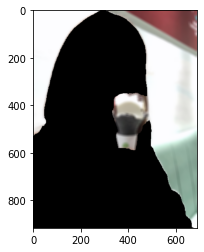

In [18]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

# 마스크 rgb로 바꿔 읽어두고
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# 마스크 반전작업하고
# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# 배경블러처리한 것과 마스크 반전한것을 and로 묶어준다.
# 마스크 반전에서 사람이 0 이었기 때문에 어떤 값과 and 해도
# 사람의 부분은 0 으로 검은색이 될 수 밖에 없다. (0 = png에서는 투명 = 사라짐)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## (5) 사람 없는 흐린배경 + 사람 선명한 원본사진 합성하기

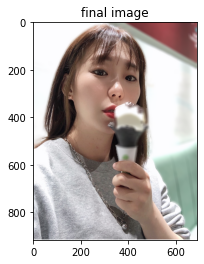

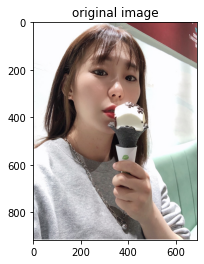

In [19]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분(사람)만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title('final image')
plt.show()
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title('original image')
plt.show()

(905, 692, 3)


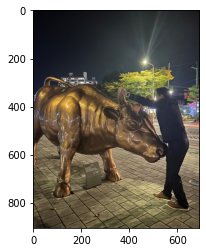

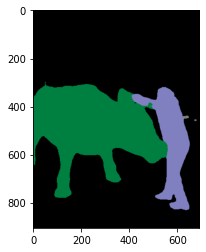

In [20]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt
# 1. 이미지 불러오기
img_path = os.getenv('HOME')+f'/aiffel/human_segmentation/images/my_image1.PNG'  
img_orig = cv2.imread(img_path) 
print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 2. 모델 준비
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 
urllib.request.urlretrieve(model_url, model_file)
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)


# 3. 이미지에 적용
segvalues, output = model.segmentAsPascalvoc(img_path)
plt.imshow(output)
plt.show() 


### 사람 외 blur 해보기

background
car
cow
person
(905, 692)


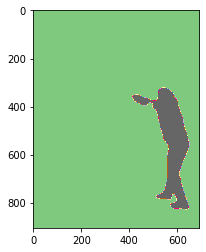

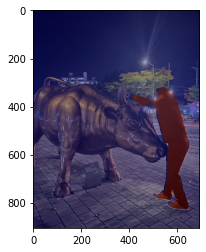

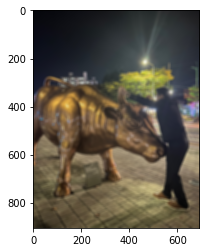

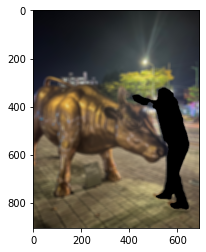

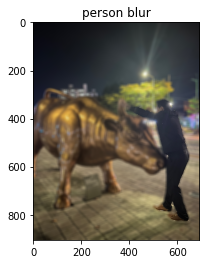

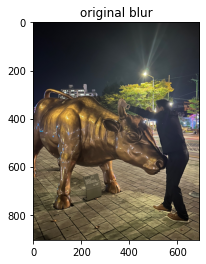

In [21]:
# 4. 요소 추출
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])
    
    
# 5. 컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

# 6. 해당 요소의 컬러맵 배열 추출해 mask 만들기
seg_person = (128,128,192)
seg_map = np.all(output==seg_person, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='Accent')
plt.show()

# 7. 원본이미지에 겹쳐보기
img_show = img_orig.copy()
img_mask = seg_map.astype(np.uint8) * 255 # 0- 255로 바꿔줌
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET) # mask 컬러주기
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0) # 해당비율로 둘 섞기
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()
#################################

# 8. 원본이미지 복제하여 전체 blur 처리
img_orig_blur = cv2.blur(img_orig, (13,13))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 9. blur이미지에서 해당부분만 mask이용 잘라내기
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) # mask rgb로 바꿔 불러옴
img_bg_mask = cv2.bitwise_not(img_mask_color) # mask 값 반전시키기 (해당부분 0이 되게)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) # blur사진 & 반전 mask and로 합성
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB)) # mask부분만 공백, 나머지는 blur
plt.show()

# 10. mask 없는 blur 사진 + mask 부분만 원본사진으로 합성하기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title('person blur')
plt.show() # 최종본

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title('original blur')
plt.show() # 원본   

## 소 외 blur 해보기

background
car
cow
person
(905, 692)


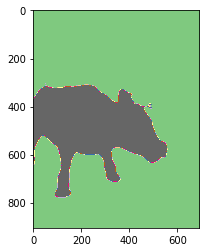

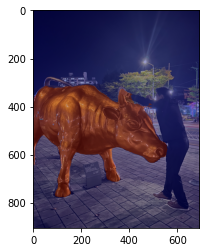

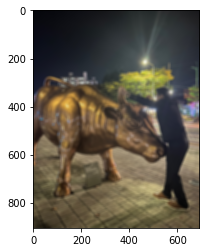

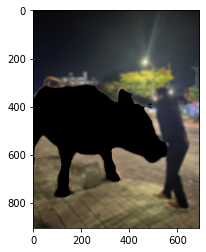

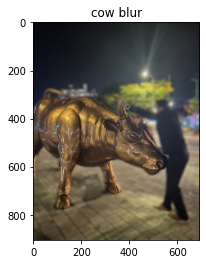

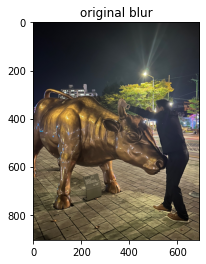

In [22]:
# 4. 요소 추출
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])
    
    
# 5. 컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

# 6. 해당 요소의 컬러맵 배열 추출해 mask 만들기
seg_person = (0, 128, 64)
seg_map = np.all(output==seg_person, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='Accent')
plt.show()

# 7. 원본이미지에 겹쳐보기
img_show = img_orig.copy()
img_mask = seg_map.astype(np.uint8) * 255 # 0- 255로 바꿔줌
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET) # mask 컬러주기
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0) # 해당비율로 둘 섞기
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()
#################################

# 8. 원본이미지 복제하여 전체 blur 처리
img_orig_blur = cv2.blur(img_orig, (13,13))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 9. blur이미지에서 해당부분만 mask이용 잘라내기
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) # mask rgb로 바꿔 불러옴
img_bg_mask = cv2.bitwise_not(img_mask_color) # mask 값 반전시키기 (해당부분 0이 되게)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) # blur사진 & 반전 mask and로 합성
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB)) # mask부분만 공백, 나머지는 blur
plt.show()

# 10. mask 없는 blur 사진 + mask 부분만 원본사진으로 합성하기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title('cow blur')
plt.show() # 최종본

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title('original blur')
plt.show() # 원본   

## 크로마키 해보기

(905, 692, 3)


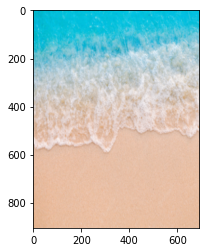

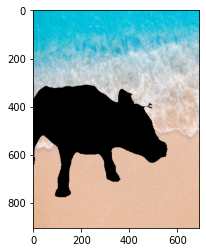

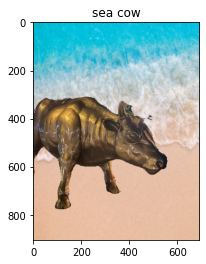

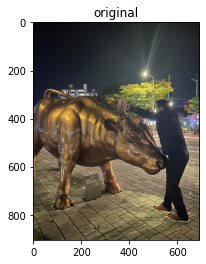

In [23]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/sea.PNG'  
img_sea = cv2.imread(img_path) 
img_sea = cv2.resize(img_sea,(692,905))
print(img_sea.shape)
plt.imshow(cv2.cvtColor(img_sea, cv2.COLOR_BGR2RGB))
plt.show() 


# 9. blur이미지에서 해당부분만 mask이용 잘라내기
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) # mask rgb로 바꿔 불러옴
img_bg_mask = cv2.bitwise_not(img_mask_color) # mask 값 반전시키기 (해당부분 0이 되게)
img_bg_sea = cv2.bitwise_and(img_sea, img_bg_mask) # blur사진 & 반전 mask and로 합성
plt.imshow(cv2.cvtColor(img_bg_sea, cv2.COLOR_BGR2RGB)) # mask부분만 공백, 나머지는 blur
plt.show()

# 10. mask 없는 blur 사진 + mask 부분만 원본사진으로 합성하기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_sea) #np.where(조건, 참일때, 거짓일때)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.title('sea cow')
plt.show() # 최종본

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.title('original')
plt.show() # 원본   

# 정리

DOF (Depth of Field) : 피사계 심도 : 사진에서 초점이 맞은 것으로 인식되는 범위
        
얕은 피사계심도(아웃포커싱)이 잘 되는 조건

1. 빛의 양이 많을 수록 (이미지센서가 클때, 조리개를 많이 열었을때 f값은 작음)
2. DOF 내의 물체, 즉 초점을 맞추고자 하는 물체가 가까이 있을수록
3. DOF 내의 물체와 외의 배경의 거리가 멀수록. 그래야 depth가 확연히 차이가 나서 잘됨.


## 9-7. 프로젝트: 인물 모드 문제점 찾기

Step 2. 사진에서 문제점 찾기

![error1](error1.PNG)
![error2](error2.PNG)


정리에서 적었던 2, 3번의 문제점이 드러나는 부분들이다. lms 기본사진으로 실행했을 때에는 사람 주변의 색상이 비슷한 부분을 함께 블러처리가 되었다. 옷이 헤더의 색상이라 좀 더 헷갈리지 않았을까 한다. 밑의 사진에서는 3번의 문제점이 나왔는데 사람이 DOF 내에 있기는 했지만, 물체와 블러처리할 배경의 거리가 너무 가까워서 depth 차이가 나지 않아 blur 처리 결과물에서 사람 역시 선명하지 않고 흐릿했다. 

Step 3. 해결 방법을 제안해 보기

- 중요요소들 : segmentation 범위, 열, 거리.

- 범위 : segmentation을 pixellib로 수행한 것 + hand crop으로 범위를 직접 지정한 것. hand crop으로 범위를 지정하던 것은 지금처럼 segmentation 기술이 발전하지 않았을 때인데, 이를 collaboration하는 것이 어떨까. 필터를 병렬로 두가지를 쓰는 법
    1. 원본이미지를 복사하여 img_copy를 만들고
    2. img_copy를 rgb 분석하여 그 사진에 없는 고유한 값으로 hand cropped 경계선을 지정하고
    3. 그 경계선이 있는 부분은 pixellib의 convolution fillter처럼 중간 r 값을 띄운 필터가 아닌 보통의 3 x 3 conv2d와 같은 작은 필터로 겹겹이 쌓아서 그 부분은 이웃되는 곳에 더 많이 영향받게 하여 색상차를 좀 더 세밀히 분석하게 하고,
    4. 경계선이 아닌 부분은 r값을 띄운 Spatial Pyramid Pooling을 하고,
    5. 필터의 종류를 달리 적용한 3,4번의 결과값을 layer로 합쳐서 weight에 그 값이 반영되기 하면
    6. 경계부분에서 부분적으로 일어나는 segmentation을 극복할 수 있지 않을까..

- 열 : 열화상카메라.. but 생물은 감지되어도 무생물은 감지되지 않는다.  
- 분자 : 생물과 무생물의 공통점을 찾아보다가 분자구조를 갖는다는 사실을 검색했고, 구체화시키지는 못했지만, 분자구조의 특징으로 segmentation 할 수 있지 않을까라는 상상을 했다. 실제로 초고감도 분자센서가 있다고 하니, 하기 링크를 첨부한다.
https://www.sciencetimes.co.kr/news/%EC%B4%88%EA%B3%A0%EA%B0%90%EB%8F%84-%EB%B6%84%EC%9E%90%EC%84%BC%EC%84%9C%EB%A1%9C-%EB%8B%A8%EB%B0%B1%EC%A7%88-%EB%B3%80%ED%99%94-%EC%A0%95%EB%B0%80-%EC%B8%A1%EC%A0%95%ED%95%9C%EB%8B%A4/


- 거리 : lms에 나왔듯이 레이저로도 거리를 탐지 가능하지만, 초음파로도 거리는 측정 가능하다. 초음파는 사람에게 들리지 않으니 카메라로 사진을 찍을 때 초음파 센서를 함께 사용하여 카메라 외 별도의 기계장치를 통해 거리를 수집하는 것은 어떨까. 

https://raduino.tistory.com/28